# Predicting Product Ratings From Web Browsing Data

In [1]:
import numpy as np
import pandas as pd
from matrix_completion import MatrixCompletionizationizer
from utils import *

# load the browsing history data
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_history_indexed = user_history.set_index('USER ID')
user_ratings = pd.read_csv("user_ratings.csv")
user_history_indexed_normalized = user_history_indexed.copy()
user_history_indexed_normalized -= user_history_indexed_normalized.mean()
user_history_indexed_normalized /= user_history_indexed_normalized.std()

# load the ratings data
train, test = split_data('user_ratings.csv')

In [2]:
FEATURE_SELECTION_METHODS = ["All features", "PCA", "KMeans then PCA", "all"]
MATRIX_COMPLETION_METHODS = ["Use web features as initial user features", "Append web features"]

FEATURE_SELECTION = FEATURE_SELECTION_METHODS[1] #set this to 0, 1, or 2, or 3 for "all"
MATRIX_COMPLETION = MATRIX_COMPLETION_METHODS[0] #set this to 0 or 1

#set hyperparameters here:
learning_rate = 0.006
num_epochs = 900
batch_size = 1000
k = 15

## I. Using unmodified web browsing data as features

In [3]:
if FEATURE_SELECTION == "All features" or FEATURE_SELECTION == "all":
    row_id_to_ind = dict(zip(user_history['USER ID'].to_numpy(), range(len(user_history['USER ID'].to_numpy()))))
    n_rows = len(row_id_to_ind)
    col_id_to_ind = dict(zip(train['PRODUCT'].unique(), range(len(train['PRODUCT'].unique()))))
    n_cols = len(col_id_to_ind)
    
    reduced_features = user_history_indexed_normalized

    added_cols = reduced_features
    added_col_id_to_ind = dict(zip(added_cols.columns.to_numpy(), range(n_cols, n_cols+added_cols.shape[1])))
    all_cols_id_to_ind = {**col_id_to_ind, **added_col_id_to_ind}
    added_cols_melted = added_cols.reset_index(inplace=False).melt('USER ID', var_name='PRODUCT', value_name='RATING')
    n_all_cols = len(all_cols_id_to_ind)

    train_appended = pd.concat([train, added_cols_melted], axis=0) 
    train_appended = train_appended.reset_index().drop(columns=['index'])

    train_ratings = train['RATING']
    train_rows = train['USER ID']
    train_cols = train['PRODUCT']

    train_ratings_appended = train_appended['RATING']
    train_rows_appended = train_appended['USER ID']
    train_cols_appended = train_appended['PRODUCT']

    test_ratings = test['RATING']
    test_rows = test['USER ID']
    test_cols = test['PRODUCT']

    row_features = reduced_features.to_numpy()
    
    if MATRIX_COMPLETION == "Append web features":
        model = MatrixCompletionizationizer(n_rows, n_all_cols, k=k)
        predicted = model.train(train_rows_appended, train_cols_appended, train_ratings_appended,
                                row_id_to_ind, all_cols_id_to_ind,
                                num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                print_loss = True, graph_loss = True, 
                                original_train_rows=train_rows, original_train_cols=train_cols, 
                                original_train_vals=train_ratings, original_col_id_to_ind=col_id_to_ind)
    elif MATRIX_COMPLETION == "Use web features as initial user features":
        model = MatrixCompletionizationizer(n_rows, n_cols, row_features=row_features)        
        predicted = model.train(train_rows, train_cols, train_ratings,
                                row_id_to_ind, col_id_to_ind,
                                num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                print_loss = True, graph_loss = True)

    test_rows_inds = np.array([row_id_to_ind[r] for r in test_rows])
    test_cols_inds = np.array([col_id_to_ind[c] for c in test_cols])

    print()
    print("Test MSE for using unprocessed history matrix:")
    print(mse(test_ratings, predicted[test_rows_inds, test_cols_inds]))
    print()
    print("Average test error (square root of MSE) for using unprocessed history matrix:")
    print(np.sqrt(mse(test_ratings, predicted[test_rows_inds, test_cols_inds])))
    print()

## II. Using web browsing data after PCA

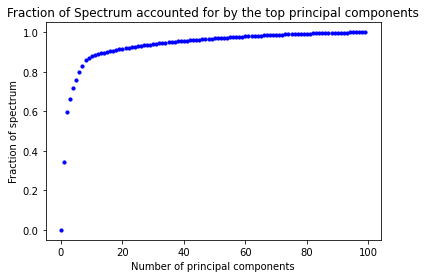

Train loss after epoch #1 is: 28.710306322772443
Train loss after epoch #90 is: 1.1313973939254187
Train loss after epoch #180 is: 0.6250917727650802
Train loss after epoch #270 is: 0.43966274733912486
Train loss after epoch #360 is: 0.35355471176854875
Train loss after epoch #450 is: 0.30212971332969807
Train loss after epoch #540 is: 0.2673989167532102
Train loss after epoch #630 is: 0.2503922180452375
Train loss after epoch #720 is: 0.23312329896157308
Train loss after epoch #810 is: 0.22321573595608166
Train loss after epoch #900 is: 0.2130365649938602


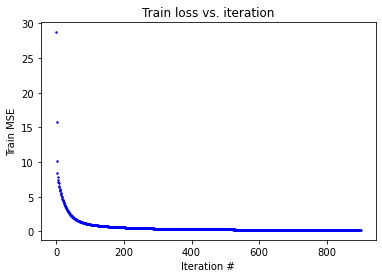


Test MSE for PCA on entire history matrix:
0.8078946843869899

Average test error (square root of MSE) for PCA on entire history matrix:
0.8988296192198997



In [4]:
if FEATURE_SELECTION == "PCA" or FEATURE_SELECTION == "all":
    row_id_to_ind = dict(zip(user_history['USER ID'].to_numpy(), range(len(user_history['USER ID'].to_numpy()))))
    n_rows = len(row_id_to_ind)
    col_id_to_ind = dict(zip(train['PRODUCT'].unique(), range(len(train['PRODUCT'].unique()))))
    n_cols = len(col_id_to_ind)

    reduced_features = PCA(user_history_indexed_normalized, user_history['USER ID'],
                           spectrum_fraction_threshold=0.9, graph_spectrum_fractions=True)

    added_cols = reduced_features
    added_col_id_to_ind = dict(zip(added_cols.columns.to_numpy(), range(n_cols, n_cols+added_cols.shape[1])))
    all_cols_id_to_ind = {**col_id_to_ind, **added_col_id_to_ind}
    added_cols_melted = added_cols.reset_index(inplace=False).melt('USER ID', var_name='PRODUCT', value_name='RATING')
    n_all_cols = len(all_cols_id_to_ind)

    train_appended = pd.concat([train, added_cols_melted], axis=0) 
    train_appended = train_appended.reset_index().drop(columns=['index'])

    train_ratings = train['RATING']
    train_rows = train['USER ID']
    train_cols = train['PRODUCT']

    train_ratings_appended = train_appended['RATING']
    train_rows_appended = train_appended['USER ID']
    train_cols_appended = train_appended['PRODUCT']

    test_ratings = test['RATING']
    test_rows = test['USER ID']
    test_cols = test['PRODUCT']

    row_features = reduced_features.to_numpy()
    
    if MATRIX_COMPLETION == "Append web features":
        model = MatrixCompletionizationizer(n_rows, n_all_cols, k=k)
        predicted = model.train(train_rows_appended, train_cols_appended, train_ratings_appended,
                                row_id_to_ind, all_cols_id_to_ind,
                                num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                print_loss = True, graph_loss = True, 
                                original_train_rows=train_rows, original_train_cols=train_cols, 
                                original_train_vals=train_ratings, original_col_id_to_ind=col_id_to_ind)
    elif MATRIX_COMPLETION == "Use web features as initial user features":
        model = MatrixCompletionizationizer(n_rows, n_cols, row_features=row_features)        
        predicted = model.train(train_rows, train_cols, train_ratings,
                                row_id_to_ind, col_id_to_ind,
                                num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                print_loss = True, graph_loss = True)

    test_rows_inds = np.array([row_id_to_ind[r] for r in test_rows])
    test_cols_inds = np.array([col_id_to_ind[c] for c in test_cols])

    print()
    print("Test MSE for PCA on entire history matrix:")
    print(mse(test_ratings, predicted[test_rows_inds, test_cols_inds]))
    print()
    print("Average test error (square root of MSE) for PCA on entire history matrix:")
    print(np.sqrt(mse(test_ratings, predicted[test_rows_inds, test_cols_inds])))
    print()

## III. Using web browsing data after PCA on individual clusters

In [5]:
if FEATURE_SELECTION == "KMeans then PCA" or FEATURE_SELECTION == "all":
    num_clusters = 3
    reduced_cluster_data, user_history_clustered = KMeansPCA(user_history_indexed_normalized, user_history['USER ID'], 'USER ID', 
                                                             num_clusters=num_clusters, spectrum_fraction_threshold=0.9,
                                                             plot_clusters=False)
    train_with_clusters = train.merge(pd.DataFrame(user_history_clustered['Cluster']).reset_index())
    test_with_clusters = test.merge(pd.DataFrame(user_history_clustered['Cluster']).reset_index())

    for cluster_ind in range(num_clusters):

        train = train_with_clusters[train_with_clusters['Cluster']==cluster_ind].drop(columns=['Cluster'])
        test = test_with_clusters[test_with_clusters['Cluster']==cluster_ind].drop(columns=['Cluster'])

        cluster_inds = reduced_cluster_data[cluster_ind].reset_index()['USER ID'].unique()
        row_id_to_ind_cluster = dict(zip(cluster_inds, range(len(cluster_inds))))
        col_id_to_ind = dict(zip(train['PRODUCT'].unique(), range(len(train['PRODUCT'].unique()))))
        n_rows = len(row_id_to_ind_cluster)
        n_cols = len(col_id_to_ind)

        reduced_features = reduced_cluster_data[cluster_ind].sort_index()
        added_cols = reduced_features
        added_col_id_to_ind = dict(zip(added_cols.columns.to_numpy(), range(n_cols, n_cols+added_cols.shape[1])))
        all_cols_id_to_ind = {**col_id_to_ind, **added_col_id_to_ind}
        added_cols_melted = added_cols.reset_index(inplace=False).melt('USER ID', var_name='PRODUCT', value_name='RATING')
        n_all_cols = len(all_cols_id_to_ind)

        train_appended = pd.concat([train, added_cols_melted], axis=0) 
        train_appended = train_appended.reset_index().drop(columns=['index'])

        train_ratings = train['RATING']
        train_rows = train['USER ID']
        train_cols = train['PRODUCT']

        train_ratings_appended = train_appended['RATING']
        train_rows_appended = train_appended['USER ID']
        train_cols_appended = train_appended['PRODUCT']

        test_ratings = test['RATING']
        test_rows = test['USER ID']
        test_cols = test['PRODUCT']

        row_features = reduced_features.to_numpy()
    
        if MATRIX_COMPLETION == "Append web features":
            model = MatrixCompletionizationizer(n_rows, n_all_cols, k=k)
            predicted = model.train(train_rows_appended, train_cols_appended, train_ratings_appended,
                                    row_id_to_ind_cluster, all_cols_id_to_ind,
                                    num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                    print_loss = True, graph_loss = True, 
                                    original_train_rows=train_rows, original_train_cols=train_cols, 
                                    original_train_vals=train_ratings, original_col_id_to_ind=col_id_to_ind)
        elif MATRIX_COMPLETION == "Use web features as initial user features":
            model = MatrixCompletionizationizer(n_rows, n_cols, row_features=row_features)        
            predicted = model.train(train_rows, train_cols, train_ratings,
                                    row_id_to_ind_cluster, col_id_to_ind,
                                    num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                                    print_loss = True, graph_loss = True)

        test_rows_inds = np.array([row_id_to_ind_cluster[r] for r in test_rows])
        test_cols_inds = np.array([all_cols_id_to_ind[c] for c in test_cols])
        print()
        print("Test MSE for cluster #" + str(cluster_ind) + ":")
        print(mse(test_ratings, predicted[test_rows_inds, test_cols_inds]))
        print()
        print("Average test error (square root of MSE) for cluster #" + str(cluster_ind) + ":")
        print(np.sqrt(mse(test_ratings, predicted[test_rows_inds, test_cols_inds])))
        print()

## IV. Final Result

Train loss after epoch #1 is: 28.323740370464087
Train loss after epoch #90 is: 1.1866197292490808
Train loss after epoch #180 is: 0.6658861502823005
Train loss after epoch #270 is: 0.47013194521205864
Train loss after epoch #360 is: 0.3734729899467634
Train loss after epoch #450 is: 0.31841427980509085
Train loss after epoch #540 is: 0.2848675514188733
Train loss after epoch #630 is: 0.26458385472563595
Train loss after epoch #720 is: 0.24966043539008423
Train loss after epoch #810 is: 0.24076041646605062
Train loss after epoch #900 is: 0.23496164733269076


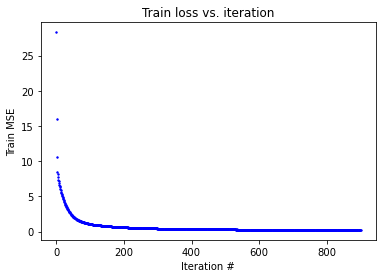

In [6]:
row_id_to_ind = dict(zip(user_history['USER ID'].to_numpy(), range(len(user_history['USER ID'].to_numpy()))))
n_rows = len(row_id_to_ind)
col_id_to_ind = dict(zip(user_ratings['PRODUCT'].unique(), range(len(user_ratings['PRODUCT'].unique()))))
n_cols = len(col_id_to_ind)

reduced_features = PCA(user_history_indexed_normalized, user_history['USER ID'],
                   spectrum_fraction_threshold=0.9, graph_spectrum_fractions=False)

added_cols = reduced_features
added_col_id_to_ind = dict(zip(added_cols.columns.to_numpy(), range(n_cols, n_cols+added_cols.shape[1])))
all_cols_id_to_ind = {**col_id_to_ind, **added_col_id_to_ind}
added_cols_melted = added_cols.reset_index(inplace=False).melt('USER ID', var_name='PRODUCT', value_name='RATING')
n_all_cols = len(all_cols_id_to_ind)

train_ratings = user_ratings['RATING']
train_rows = user_ratings['USER ID']
train_cols = user_ratings['PRODUCT']

row_features = reduced_features.to_numpy()

model = MatrixCompletionizationizer(n_rows, n_cols, row_features=row_features)        
predicted = model.train(train_rows, train_cols, train_ratings,
                        row_id_to_ind, col_id_to_ind,
                        num_epochs=num_epochs, batch_size=batch_size, learning_rate = learning_rate,
                        print_loss = True, graph_loss = True)
predictions = pd.DataFrame(predicted, columns = col_id_to_ind)
predictions['USER ID'] = row_id_to_ind

In [7]:
predictions = predictions.melt(id_vars = 'USER ID', var_name='PRODUCT', value_name='RATING')
predictions = predictions.set_index('USER ID')
predictions.to_csv('predictions.csv')

In [8]:
pd.read_csv('predictions.csv')

,USER ID,PRODUCT,RATING
0,100950,secret postage,3.784134
1,100956,secret postage,4.599702
2,100962,secret postage,7.028474
3,100969,secret postage,0.000000
4,100974,secret postage,10.000000
...,...,...,...
337495,125614,bazooka diagram,4.975373
337496,125622,bazooka diagram,4.685992
337497,125629,bazooka diagram,4.246208
337498,125636,bazooka diagram,8.484014
